# Basic download data, web map, isochrone, centrality

## Download data with bbox

From bbox http://bboxfinder.com/#-34.439112,-72.050409,-34.379547,-71.982082

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.0'

In [2]:
# define a bounding box n, s, e, w
# copy from bbox WSEN (reorder!) -72.050409,-34.439112,-71.982082,-34.379547
north, south, east, west = -34.379547, -34.439112, -71.982082, -72.050409

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')

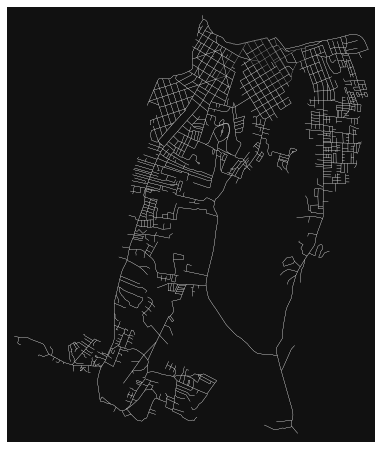

In [3]:
# simple plot
fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)

In [4]:
# save graph G as geopackage
ox.save_graph_geopackage(G, filepath='./data/basic_graph.gpkg')

## Web map

In [5]:
#G.edges.data()

In [6]:
from IPython.display import IFrame

In [7]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='osmid', edge_width=1)

In [8]:
# save as html file then display map as an iframe
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [9]:
#G.graph

## Isochrone

Includes reprojection to UTM for distance calculations

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from osgeo import ogr, osr
from shapely.geometry import Point, LineString, Polygon
import shapely.wkt
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.0'

In [11]:
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [12]:
# define a bounding box n, s, e, w
# copy from bbox WSEN (reorder!) -72.050409,-34.439112,-71.982082,-34.379547
north, south, east, west = -34.379547, -34.439112, -71.982082, -72.050409

# download the street network
G = ox.graph_from_bbox(north, south, east, west, network_type=network_type)

In [13]:
# project graph to UTM
G = ox.project_graph(G)

In [14]:
# check CRS
G.graph

{'created_date': '2020-09-28 19:01:12',
 'created_with': 'OSMnx 0.16.0',
 'crs': <Projected CRS: +proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +unit ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: UTM zone 18N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 'simplified': True,
 'streets_per_node': {314165547: 3,
  314165626: 3,
  314166167: 3,
  314166248: 4,
  314166249: 3,
  314166433: 3,
  314167115: 3,
  314176970: 3,
  314176982: 3,
  314176985: 4,
  360069435: 6,
  360069462: 3,
  360069469: 4,
  360069476: 3,
  360069832: 4,
  360069841: 4,
  360069956: 3,
  360069966: 3,
  360069979: 3,
  360501153: 3,
  360501166: 4,
  360501172: 4,
  360501187: 3,
  360501197: 3,
  360501204: 3,
  360501216: 3,
  360501232: 4,
  360501233: 3,
  360501234: 4,
  360501236: 4,
  360501241: 4,
  360501244: 4,
  360501

In [15]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [16]:
# define origin (from bbox in UTM) 774218.4487,6190805.1656
center_node = ox.get_nearest_node(G, (774218.4487,6190805.1656))

In [17]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

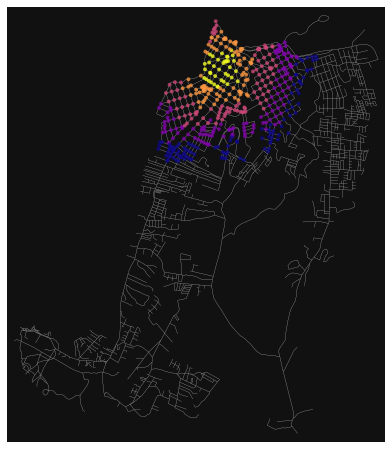

In [18]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

In [19]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

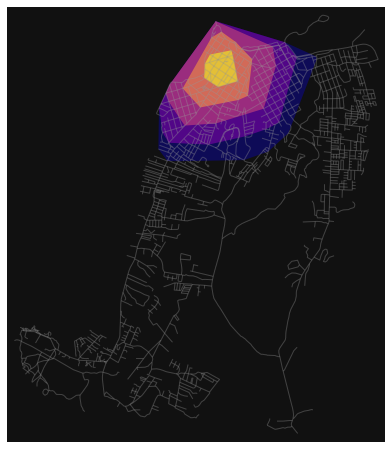

In [20]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

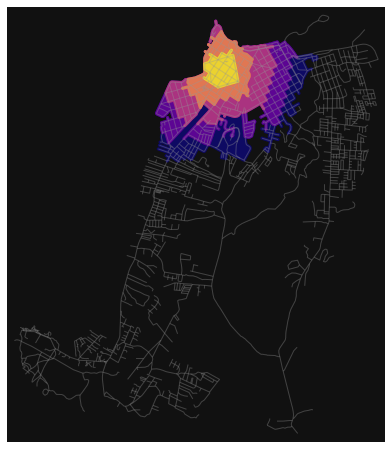

In [21]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

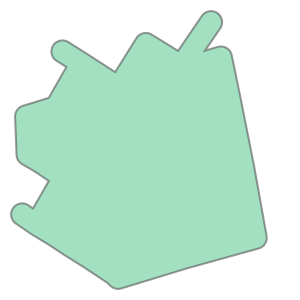

In [22]:
# plot 5 min catchment
isochrone_polys[4]

In [23]:
#the wkt for the 400m (isochrone 4)
P = shapely.wkt.loads(isochrone_polys[4].wkt)

# Now convert it to a shapefile with OGR

sr = osr.SpatialReference()
# or sr.ImportFromProj4(edges.crs)
# copy from check CRS after UTM projection
sr.ImportFromProj4('+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +unit') 
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource('data/iso4.shp')
layer = ds.CreateLayer('route', sr, ogr.wkbPolygon)# Add one attribute
layer.CreateField(ogr.FieldDefn('id', ogr.OFTInteger))
defn = layer.GetLayerDefn()

## If there are multiple geometries, put the "for" loop here

# Create a new feature (attribute and geometry)
feat = ogr.Feature(defn)
feat.SetField('id', 123)

# Make a geometry, from Shapely object
geom = ogr.CreateGeometryFromWkb(P.wkb)
feat.SetGeometry(geom)
layer.CreateFeature(feat)
feat =  None 

# Save and close the data source
ds = None

In [24]:
# convert isochrone to geopackage
gs = gpd.GeoSeries(isochrone_polys)

In [25]:
gs

0    POLYGON ((773738.592 -3810644.236, 773738.254 ...
1    POLYGON ((774246.134 -3810401.370, 774245.842 ...
2    POLYGON ((773935.769 -3810064.468, 773935.477 ...
3    POLYGON ((774149.648 -3809806.649, 774149.584 ...
4    POLYGON ((774412.965 -3809498.040, 774412.312 ...
dtype: geometry

In [26]:
# WGS 84 UTM zone 18 https://epsg.io/32618
# check CRS of iso4.shp in QGIS
# https://proj.org/_images/utm_zones.png
gs = gs.set_crs(epsg=32618, allow_override=True)

In [27]:
gs.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 78°W to 72°W - by country
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
# save to geopackage
gs.to_file("data/isochrones.gpkg", layer='isochrones', driver="GPKG")

## Centrality

In [29]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import networkx as nx
import osmnx as ox
import pandas as pd
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.0'

In [30]:
# define a bounding box n, s, e, w
# copy from bbox WSEN (reorder!) -72.050409,-34.439112,-71.982082,-34.379547
north, south, east, west = -34.379547, -34.439112, -71.982082, -72.050409

# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_bbox(north, south, east, west, network_type='drive'))
stats['circuity_avg']

1.0764526817270155

In [31]:
# download the street network
G = ox.graph_from_bbox(north, south, east, west, network_type=network_type)

In [32]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.Series(stats)

n                                                                                   1524
m                                                                                   4130
k_avg                                                                            5.41995
intersection_count                                                                  1154
streets_per_node_avg                                                             2.71719
streets_per_node_counts                {0: 0, 1: 370, 2: 0, 3: 860, 4: 286, 5: 2, 6: ...
streets_per_node_proportion            {0: 0.0, 1: 0.24278215223097113, 2: 0.0, 3: 0....
edge_length_total                                                                 408206
edge_length_avg                                                                  98.8391
street_length_total                                                               204103
street_length_avg                                                                98.8391
street_segments_count

In [33]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats, name='value'))

,value
n,1524.000000
m,4130.000000
k_avg,5.419948
intersection_count,1154.000000
streets_per_node_avg,2.717192
edge_length_total,408205.566000
edge_length_avg,98.839120
street_length_total,204102.783000
street_length_avg,98.839120
street_segments_count,2065.000000


In [34]:
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(1680948167, 0.2589768965222696)

In the study area, the node with the highest betweenness centrality has ~30% of all shortest paths running through it. Let's highlight it in the plot:

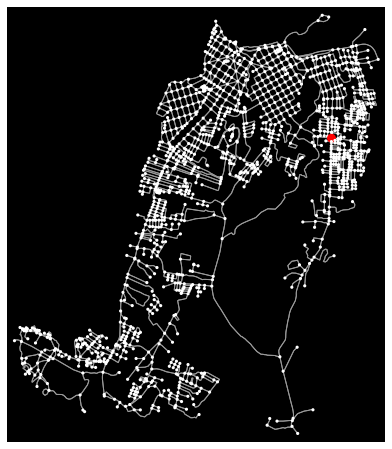

In [35]:
nc = ['r' if node==max_node else 'w' for node in G_projected.nodes()]
ns = [80 if node==max_node else 10 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

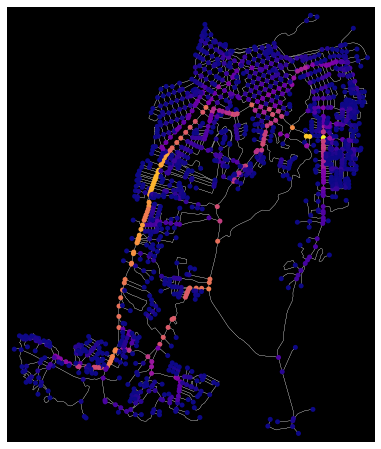

In [36]:
# relative betweenness centrality
nx.set_node_attributes(G, extended_stats['betweenness_centrality'], 'bc')
nc = ox.plot.get_node_colors_by_attr(G, 'bc', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=25, node_zorder=2,
                        edge_linewidth=0.2, edge_color='w', bgcolor='k')

# OSM Geometries

In [92]:
# get polygon from isochrone
gsa = gs

In [93]:
gsa.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 78°W to 72°W - by country
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [94]:
# reproject 
gsa = gsa.to_crs(epsg=4326)

In [95]:
gsa.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

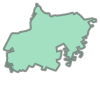

In [96]:
# polygon id=4
gsa[0]

In [97]:
# retrieve AMENITIES within polygon
#https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries
tags = {'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}
a0 = ox.geometries.geometries_from_polygon(gsa[0], tags=tags)

In [98]:
# number of (gemetries, attributes) (rows, columns)
a0.shape

(124, 54)

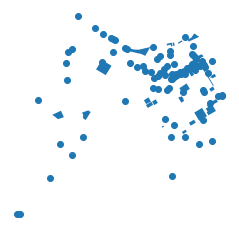

In [99]:
ax = a0.plot()
_ = ax.axis('off')

In [100]:
a0

,unique_id,osmid,element_type,highway,geometry,amenity,name,opening_hours,dispensing,operator,...,fuel:octane_95,fuel:octane_97,payment:american_express,payment:cash,payment:diners_club,payment:mastercard,payment:visa,shop,payment:coins,ways
0,node/593144790,593144790,node,NaN,POINT (-72.00596 -34.38736),pharmacy,Farmacia Posto Verde,Mo-Sa 10:00-24:00; Su 10:00-14:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/601265159,601265159,node,NaN,POINT (-72.00314 -34.38635),pharmacy,Farmacia Pichilemu,Mo-Sa 10:00-24:00; Su 10:00-14:00,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/601345105,601345105,node,bus_stop,POINT (-72.00242 -34.38977),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/601345106,601345106,node,bus_stop,POINT (-72.00503 -34.39273),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/601345107,601345107,node,NaN,POINT (-72.01084 -34.38626),nightclub,Barracuda,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,way/576883534,576883534,way,NaN,"POLYGON ((-72.00567 -34.38847, -72.00534 -34.3...",courthouse,Juzgado de Familia Pichilemu,NaN,NaN,Juzgado de Familia de Pichilemu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,way/629312796,629312796,way,NaN,"POLYGON ((-72.00162 -34.38966, -72.00179 -34.3...",fuel,Petrobras,NaN,NaN,Petrobras,...,yes,yes,yes,yes,yes,yes,yes,NaN,no,NaN
121,way/642573716,642573716,way,NaN,"POLYGON ((-72.00752 -34.39181, -72.00746 -34.3...",courthouse,Defensoría local de Pichilemu,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,way/829952664,829952664,way,NaN,"POLYGON ((-72.01404 -34.38646, -72.01420 -34.3...",parking,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# filter node element types
a0n = a0[a0['element_type']=='node']

In [102]:
a0n.shape

(97, 54)

In [103]:
# filter way element types
a0w = a0[a0['element_type']=='way']

In [104]:
a0w

,unique_id,osmid,element_type,highway,geometry,amenity,name,opening_hours,dispensing,operator,...,fuel:octane_95,fuel:octane_97,payment:american_express,payment:cash,payment:diners_club,payment:mastercard,payment:visa,shop,payment:coins,ways
97,way/47202851,47202851,way,NaN,"POLYGON ((-72.01343 -34.38733, -72.01285 -34.3...",hospital,Hospital de Pichilemu,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,way/47202932,47202932,way,NaN,"POLYGON ((-72.00358 -34.39130, -72.00276 -34.3...",school,Escuela Digna Camilo Aguilar,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,way/47202975,47202975,way,NaN,"POLYGON ((-72.00466 -34.39147, -72.00413 -34.3...",school,Charly's School,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,way/47203034,47203034,way,NaN,"POLYGON ((-72.00276 -34.38996, -72.00265 -34.3...",school,Liceo Agustín Ross Edwards,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,way/47273046,47273046,way,NaN,"POLYGON ((-72.00543 -34.38916, -72.00522 -34.3...",place_of_worship,Parroquia Inmaculada Concepción,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,way/47281069,47281069,way,NaN,"POLYGON ((-72.00214 -34.38832, -72.00196 -34.3...",police,3 Comisaría Pichilemu,NaN,NaN,Carabineros de Chile,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,way/47283149,47283149,way,NaN,"POLYGON ((-72.00233 -34.38739, -72.00229 -34.3...",theatre,Teatro Pista Municipal,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,way/47768308,47768308,way,NaN,"POLYGON ((-72.00920 -34.38993, -72.00862 -34.3...",school,Colegio Preciosa Sangre,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,way/47768310,47768310,way,NaN,"POLYGON ((-72.00854 -34.38963, -72.00817 -34.3...",school,Colegio Preciosa Sangre,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,way/47768312,47768312,way,NaN,"POLYGON ((-72.00893 -34.38926, -72.00941 -34.3...",school,Colegio Preciosa Sangre,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# convert to nodes (shows caveats because of geographic-project CRS)
a0w['geometry'] = a0w['geometry'].centroid

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/srv/conda/envs/notebook/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [106]:
# filter relation element types
a0r = a0[a0['element_type']=='relation']

In [107]:
a0r

,unique_id,osmid,element_type,highway,geometry,amenity,name,opening_hours,dispensing,operator,...,fuel:octane_95,fuel:octane_97,payment:american_express,payment:cash,payment:diners_club,payment:mastercard,payment:visa,shop,payment:coins,ways
123,relation/2765534,2765534,relation,NaN,"MULTIPOLYGON (((-72.00701 -34.38461, -72.00647...",townhall,Logística Municipalidad de Pichilemu,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[205837766, 205837764]"


In [108]:
# convert to nodes (shows caveats because of geographic-project CRS)
a0r['geometry'] = a0r['geometry'].centroid

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/srv/conda/envs/notebook/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [109]:
# concatenate all together as point geometries (bind)
a0full = pd.concat([a0n, a0w, a0r])

In [110]:
a0full.shape

(124, 54)

In [111]:
a0full.head()

,unique_id,osmid,element_type,highway,geometry,amenity,name,opening_hours,dispensing,operator,...,fuel:octane_95,fuel:octane_97,payment:american_express,payment:cash,payment:diners_club,payment:mastercard,payment:visa,shop,payment:coins,ways
0,node/593144790,593144790,node,NaN,POINT (-72.00596 -34.38736),pharmacy,Farmacia Posto Verde,Mo-Sa 10:00-24:00; Su 10:00-14:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/601265159,601265159,node,NaN,POINT (-72.00314 -34.38635),pharmacy,Farmacia Pichilemu,Mo-Sa 10:00-24:00; Su 10:00-14:00,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/601345105,601345105,node,bus_stop,POINT (-72.00242 -34.38977),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/601345106,601345106,node,bus_stop,POINT (-72.00503 -34.39273),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/601345107,601345107,node,NaN,POINT (-72.01084 -34.38626),nightclub,Barracuda,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
#a0full = a0full.drop(['ways'], axis = 1)

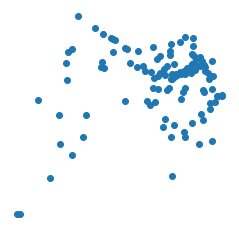

In [113]:
ax = a0full.plot()
_ = ax.axis('off')

In [114]:
# check types
a0full.dtypes

unique_id                     object
osmid                          int64
element_type                  object
highway                       object
geometry                    geometry
amenity                       object
name                          object
opening_hours                 object
dispensing                    object
operator                      object
phone                         object
cuisine                       object
currency:CLP                  object
addr:housenumber              object
addr:street                   object
studio                        object
type                          object
website                       object
bench                         object
shelter                       object
alt_name                      object
information                   object
tourism                       object
addr:city                     object
addr:housename                object
building                      object
brand                         object
a

In [115]:
# check (rows, columns) (to allow saving geopackage)
a0full.shape

(124, 54)

In [116]:
# drop columns (7:54)
a0f = a0full
a0f.drop(a0f.columns[7:54],axis=1,inplace=True)

In [117]:
# check types
a0f.dtypes

unique_id         object
osmid              int64
element_type      object
highway           object
geometry        geometry
amenity           object
name              object
dtype: object

In [118]:
# save amenities to geopackage
a0f.to_file("data/a0f.gpkg", layer='a0f', driver="GPKG")